In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler

from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# King County House Price Prediction

## Introduction

### Background
> - King County is located in the U.S. state of Washington. The population was 2,252,782 in the 2019 census estimate, making it the most populous county in Washington, and the 12th-most populous in the United States. The county seat is Seattle, also the state's most populous city.
- How much reasonable price for house in King County?

### Goal
> Predict a reasonable house price in King County

### About Data
> We got this data from Kaggle: https://www.kaggle.com/harlfoxem/housesalesprediction

In [3]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/kc_house_data.csv', parse_dates=['date'])
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Feature Description
- id : Unique id for each home sold
- date : Date of the home sale
- price : Price of each home sold
- bedrooms : Number of bedrooms
- bathrooms : Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- sqft_living : Square footage of the apartments interior living space
- sqft_lot : Square footage of land space
- floors : Number of floors
- waterfront : A dummy variable for whether the apartment was overlooking the waterfront or not
- view : An index from 0 to 4 of how good the view of the property was
- condition : An index from 1 to 5 on the condition of the apartment
- grade : An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design
- sqft_above : The square footage of the interior housing space that is above ground level
- sqft_basement : The square footage of the interior housing space that is below ground level
- yr_built : The year the house was initally built
- yr_renovated : The year of the house's last renovation
- zipcode : What zipcode area the house is in
- lat : Latitude
- long : Longitude
- sqft_living15 : The square footage of interior housing living space for the nearest 15 neighbors
- sqft_lot15 : The square footage of the land lots of the nearest 15 neighbors

## Data Exploration

In [4]:
pd.set_option('display.float_format', '{:.1f}'.format)
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0
mean,4580301520.9,540088.1,3.4,2.1,2079.9,15107.0,1.5,0.0,0.2,3.4,7.7,1788.4,291.5,1971.0,84.4,98077.9,47.6,-122.2,1986.6,12768.5
std,2876565571.3,367127.2,0.9,0.8,918.4,41420.5,0.5,0.1,0.8,0.7,1.2,828.1,442.6,29.4,401.7,53.5,0.1,0.1,685.4,27304.2
min,1000102.0,75000.0,0.0,0.0,290.0,520.0,1.0,0.0,0.0,1.0,1.0,290.0,0.0,1900.0,0.0,98001.0,47.2,-122.5,399.0,651.0
25%,2123049194.0,321950.0,3.0,1.8,1427.0,5040.0,1.0,0.0,0.0,3.0,7.0,1190.0,0.0,1951.0,0.0,98033.0,47.5,-122.3,1490.0,5100.0
50%,3904930410.0,450000.0,3.0,2.2,1910.0,7618.0,1.5,0.0,0.0,3.0,7.0,1560.0,0.0,1975.0,0.0,98065.0,47.6,-122.2,1840.0,7620.0
75%,7308900445.0,645000.0,4.0,2.5,2550.0,10688.0,2.0,0.0,0.0,4.0,8.0,2210.0,560.0,1997.0,0.0,98118.0,47.7,-122.1,2360.0,10083.0
max,9900000190.0,7700000.0,33.0,8.0,13540.0,1651359.0,3.5,1.0,4.0,5.0,13.0,9410.0,4820.0,2015.0,2015.0,98199.0,47.8,-121.3,6210.0,871200.0


In [5]:
desc = []
for i in df.columns:
    desc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((df[i].isna().sum()/len(df))*100),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data=desc, columns=['Feature','Dtypes','Null','%Null','Nunique','Sample_Unique'])

,Feature,Dtypes,Null,%Null,Nunique,Sample_Unique
0,id,int64,0,0.0,21436,"[1939000010, 8564850200]"
1,date,datetime64[ns],0,0.0,372,"[2015-04-30T00:00:00.000000000, 2014-09-16T00:..."
2,price,float64,0,0.0,4028,"[308900.0, 519900.0]"
3,bedrooms,int64,0,0.0,13,"[0, 8]"
4,bathrooms,float64,0,0.0,30,"[2.0, 1.5]"
5,sqft_living,int64,0,0.0,1038,"[2134, 2588]"
6,sqft_lot,int64,0,0.0,9782,"[54885, 7307]"
7,floors,float64,0,0.0,6,"[3.0, 3.5]"
8,waterfront,int64,0,0.0,2,"[0, 1]"
9,view,int64,0,0.0,5,"[3, 2]"


In [6]:
## Check outliers in price feature
pd.set_option('display.float_format', '{:.1f}'.format)
df['price'].describe()

count     21613.0
mean     540088.1
std      367127.2
min       75000.0
25%      321950.0
50%      450000.0
75%      645000.0
max     7700000.0
Name: price, dtype: float64

In [7]:
Q1 = df['price'].describe()['25%']
Q3 = df['price'].describe()['75%']
IQR = Q3 - Q1
upper_fence = Q3 + (1.5 * IQR)
lower_fence = Q1 - (1.5 * IQR)

print('Outliers price under lower_fence: ',len(df[df['price'] < lower_fence]))
print('Outliers price above upper_fence: ',len(df[df['price'] > upper_fence]))

Outliers price under lower_fence:  0
Outliers price above upper_fence:  1146


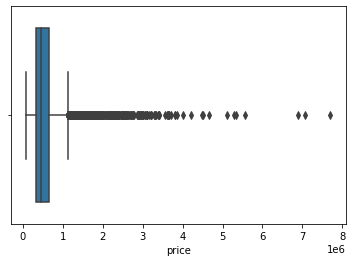

In [8]:
sns.boxplot(df['price'])
plt.show()

## Data Analysis & Data Visualization

### Univariate

In [9]:
df['date'].describe()

count                   21613
unique                    372
top       2014-06-23 00:00:00
freq                      142
first     2014-05-02 00:00:00
last      2015-05-27 00:00:00
Name: date, dtype: object

In [10]:
df['date'].value_counts()

2014-06-23    142
2014-06-25    131
2014-06-26    131
2014-07-08    127
2015-04-27    126
             ... 
2014-07-27      1
2015-03-08      1
2014-11-02      1
2015-05-15      1
2015-05-24      1
Name: date, Length: 372, dtype: int64

- There is date feature, that contain date home sale. We can extract the year home sale, so we can know about year this data is made and we can know about age a house

In [11]:
## Extract Year from date feature
sale_dt = df['date'].dt
df['year_sale'] = sale_dt.year

In [12]:
df['year_sale'].describe()

count   21613.0
mean     2014.3
std         0.5
min      2014.0
25%      2014.0
50%      2014.0
75%      2015.0
max      2015.0
Name: year_sale, dtype: float64

In [13]:
df['year_sale'].unique()

array([2014, 2015])

In [14]:
df['year_sale'].value_counts()

2014    14633
2015     6980
Name: year_sale, dtype: int64

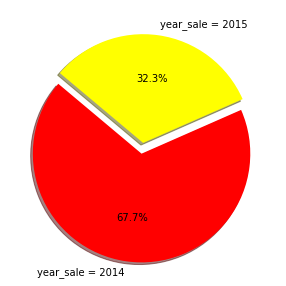

In [15]:
labels = 'year_sale = 2014', 'year_sale = 2015'
sizes = [14633, 6980]
colors = ['red', 'yellow']
explode = (0.1, 0)
plt.figure(figsize=(10,5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

- In my opinion this data is made in 2016
- This data contains house that sale in 2014 and 2015, 67.7% sale in 2014, 32.3% sale in 2015

In [16]:
## Make new features 'house_age', get from ('year_sale' - 'yr_built')
df['house_age'] = df['year_sale'] - df['yr_built']

In [17]:
df['house_age'].describe()

count   21613.0
mean       43.3
std        29.4
min        -1.0
25%        18.0
50%        40.0
75%        63.0
max       115.0
Name: house_age, dtype: float64

In [18]:
df[df['house_age'] == -1.0].head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sale,house_age
1763,1832100030,2014-06-25,597326.0,4,4.0,3570,8250,2.0,0,0,3,10,2860,710,2015,0,98040,47.6,-122.2,2230,10000,2014,-1
2687,3076500830,2014-10-29,385195.0,1,1.0,710,6000,1.5,0,0,3,6,710,0,2015,0,98144,47.6,-122.3,1440,4800,2014,-1
7526,9520900210,2014-12-31,614285.0,5,2.8,2730,6401,2.0,0,0,3,8,2730,0,2015,0,98072,47.8,-122.2,2520,6126,2014,-1


In [19]:
df['house_age'].unique()

array([ 59,  63,  82,  49,  28,  13,  19,  52,  55,  12,  50,  72,  87,
        37, 115,  36,  20,  98,  93,  46,  67,  29,  73,  99, 105,  66,
        10,  11,   9,  85,  33,  84,  81, 110,  18,  14,  30,   0,  92,
        62,  64,  34,  88,   6,  24,  60,  41,  35,  89,  25,  43,  58,
        74,  22,  51,  53,   8,  26,  75,  68,  48,  39, 104,  31, 114,
         4,  69,  65,  90,  27, 101,  47,  54, 109,   7,  61,  15,  38,
        16, 113,  21,  94,  45, 100, 111,  96,  97,  86, 103,  78,  77,
        76, 107,  40,  57, 102,  17,  71,   1,  23,  91,  42,  95,   2,
        32,   3,  56,  70,  44, 112,   5,  80,  83, 106, 108,  79,  -1])

In [20]:
df['house_age'].value_counts().head()

9     473
8     443
11    433
0     430
10    428
Name: house_age, dtype: int64

- There are some house with age -1 as well as being the youngest age. Those house are built in 2015 but sale in 2014. In my opinion maybe this case like town house selling where the house is marketed first then if someone buys, the house is just built
- Mean age of house in this data is 43 years old. Median age of house in this data is 40 years old
- The oldest houses are 115 years old

In [21]:
df['price'].value_counts().head()

450000.0    172
350000.0    172
550000.0    159
500000.0    152
425000.0    150
Name: price, dtype: int64

In [22]:
df['price'].describe()

count     21613.0
mean     540088.1
std      367127.2
min       75000.0
25%      321950.0
50%      450000.0
75%      645000.0
max     7700000.0
Name: price, dtype: float64

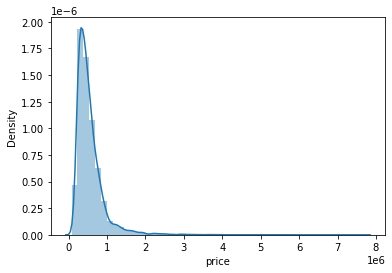

In [23]:
sns.distplot(df['price'])
plt.show()

- We will binning price feature:
  - under_median: 0 - 449999
  - median: 450000 (median price)
  - above_median: 450001 - 7700000

In [24]:
df['price_bins'] = pd.cut(df['price'], bins=[0,449999,450000,7700000], labels=['under_median','median','above_median'])
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sale,house_age,price_bins
0,7129300520,2014-10-13,221900.0,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5,-122.3,1340,5650,2014,59,under_median
1,6414100192,2014-12-09,538000.0,3,2.2,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7,-122.3,1690,7639,2014,63,above_median
2,5631500400,2015-02-25,180000.0,2,1.0,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7,-122.2,2720,8062,2015,82,under_median
3,2487200875,2014-12-09,604000.0,4,3.0,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5,-122.4,1360,5000,2014,49,above_median
4,1954400510,2015-02-18,510000.0,3,2.0,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6,-122.0,1800,7503,2015,28,above_median


In [25]:
df['price_bins'].value_counts()

above_median    10749
under_median    10692
median            172
Name: price_bins, dtype: int64

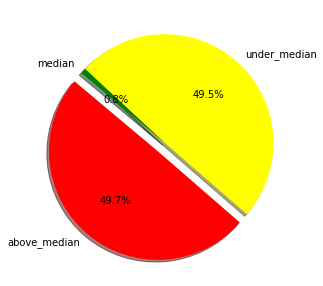

In [26]:
labels = 'above_median', 'under_median','median'
sizes = [10749, 10692, 172]
colors = ['red', 'yellow','green']
explode = (0.1, 0, 0)
plt.figure(figsize=(10,5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

- Most expensive house has price 7700000 and the cheapest has price 75000
- 49.7% (10749) house's price is above median
- 49.5% (10692) house's price is under median
- 0.8 % (172) house's price is same with median

In [27]:
df['bedrooms'].describe()

count   21613.0
mean        3.4
std         0.9
min         0.0
25%         3.0
50%         3.0
75%         4.0
max        33.0
Name: bedrooms, dtype: float64

In [28]:
df['bedrooms'].unique()

array([ 3,  2,  4,  5,  1,  6,  7,  0,  8,  9, 11, 10, 33])

In [29]:
df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
8       13
0       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [30]:
df['bedrooms'].value_counts(normalize=True)* 100

3    45.5
4    31.8
2    12.8
5     7.4
6     1.3
1     0.9
7     0.2
8     0.1
0     0.1
9     0.0
10    0.0
11    0.0
33    0.0
Name: bedrooms, dtype: float64

- In this data mostly house has 3 bedrooms
- There are some house with 0 bedrooms, in my opinion maybe that can be studio apartment or flat
- There is a house with 33 bedrooms, in my opinion maybe that can be big mansion

In [31]:
df['bathrooms'].describe()

count   21613.0
mean        2.1
std         0.8
min         0.0
25%         1.8
50%         2.2
75%         2.5
max         8.0
Name: bathrooms, dtype: float64

In [32]:
df['bathrooms'].value_counts().head()

2.5    5380
1.0    3852
1.8    3048
2.2    2047
2.0    1930
Name: bathrooms, dtype: int64

In [33]:
df['bathrooms'].value_counts(normalize=True).head() * 100

2.5   24.9
1.0   17.8
1.8   14.1
2.2    9.5
2.0    8.9
Name: bathrooms, dtype: float64

- In this data mostly house has 2.5 bathrooms. That means there are 1 bathrooms only with toilet

In [34]:
df['sqft_living'].describe()

count   21613.0
mean     2079.9
std       918.4
min       290.0
25%      1427.0
50%      1910.0
75%      2550.0
max     13540.0
Name: sqft_living, dtype: float64

In [35]:
df['sqft_living'].nunique()

1038

In [36]:
df['sqft_living'].value_counts()

1300    138
1400    135
1440    133
1010    129
1660    129
       ... 
3001      1
4970      1
2905      1
2793      1
1975      1
Name: sqft_living, Length: 1038, dtype: int64

- The most spacious house in this data, covering an area of ​​13540 sqft
- The smallest house in this data, covering an area of 290 sqft
- Mostly sqft_living in 1300, 1400, 1440, 1010, 1660 sqft

In [37]:
df['sqft_lot'].describe()

count     21613.0
mean      15107.0
std       41420.5
min         520.0
25%        5040.0
50%        7618.0
75%       10688.0
max     1651359.0
Name: sqft_lot, dtype: float64

In [38]:
df['sqft_lot'].value_counts()

5000     358
6000     290
4000     251
7200     220
4800     120
        ... 
38884      1
17313      1
35752      1
937        1
14321      1
Name: sqft_lot, Length: 9782, dtype: int64

- The biggest lot here is 1651359 sqft, in my opinion maybe this can be farmer house
- The smallest lot here is 520 sqft, in my opinion maybe this can be mini apartement or flat
- Mostly sqft lot here are 5000, 6000, 4000, 7200, 4800 sqft

In [39]:
df['floors'].describe()

count   21613.0
mean        1.5
std         0.5
min         1.0
25%         1.0
50%         1.5
75%         2.0
max         3.5
Name: floors, dtype: float64

In [40]:
df['floors'].value_counts()

1.0    10680
2.0     8241
1.5     1910
3.0      613
2.5      161
3.5        8
Name: floors, dtype: int64

- Mostly floor's house in this data are 1 and 2 floors

In [41]:
df['waterfront'].describe()

count   21613.0
mean        0.0
std         0.1
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         1.0
Name: waterfront, dtype: float64

In [42]:
df['waterfront'].value_counts()

0    21450
1      163
Name: waterfront, dtype: int64

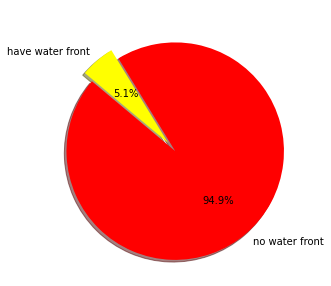

In [43]:
labels = 'no water front', 'have water front'
sizes = [21450, 1163]
colors = ['red', 'yellow']
explode = (0.1, 0)
plt.figure(figsize=(10,5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

- Mostly houses in this data (94.9%) haven't waterfront

In [44]:
df['view'].describe()

count   21613.0
mean        0.2
std         0.8
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         4.0
Name: view, dtype: float64

In [45]:
df['view'].value_counts()

0    19489
2      963
3      510
1      332
4      319
Name: view, dtype: int64

- We can say:
  - 0: no view
  - 1: bad view
  - 2: good view
  - 3: very good view
  - 4: best view

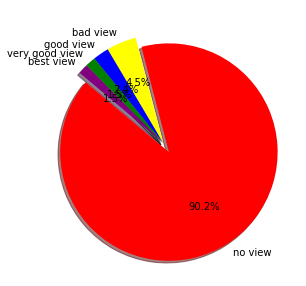

In [46]:
labels = 'no view','bad view','good view','very good view','best view'
sizes = [19489, 963, 510, 332, 319]
colors = ['red', 'yellow', 'blue', 'green', 'purple']
explode = (0.1, 0, 0, 0, 0)
plt.figure(figsize=(10,5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

In [47]:
df['view'].value_counts(normalize=True) * 100

0   90.2
2    4.5
3    2.4
1    1.5
4    1.5
Name: view, dtype: float64

- Mostly houses in this data haven't view

In [48]:
df['condition'].describe()

count   21613.0
mean        3.4
std         0.7
min         1.0
25%         3.0
50%         3.0
75%         4.0
max         5.0
Name: condition, dtype: float64

In [49]:
df['condition'].value_counts()

3    14031
4     5679
5     1701
2      172
1       30
Name: condition, dtype: int64

- We can say:
  - 1: very bad condition
  - 2: bad condition
  - 3: good condition
  - 4: very good condition
  - 5: best condition

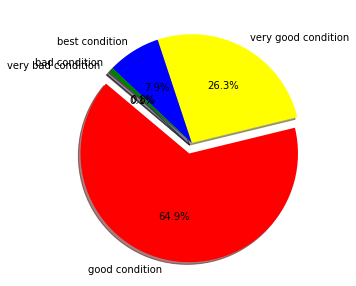

In [50]:
labels = 'good condition','very good condition','best condition','bad condition','very bad condition'
sizes = [14031, 5679, 1701, 172, 30]
colors = ['red', 'yellow', 'blue', 'green', 'purple']
explode = (0.1, 0, 0, 0, 0)
plt.figure(figsize=(10,5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

In [51]:
df['condition'].value_counts(normalize=True)*100

3   64.9
4   26.3
5    7.9
2    0.8
1    0.1
Name: condition, dtype: float64

- Mostly houses in this data (64.9%) has good condition
- 26.3% has very good condition
- 7.9% has best condition

In [52]:
df['grade'].describe()

count   21613.0
mean        7.7
std         1.2
min         1.0
25%         7.0
50%         7.0
75%         8.0
max        13.0
Name: grade, dtype: float64

In [53]:
df['grade'].value_counts()

7     8981
8     6068
9     2615
6     2038
10    1134
11     399
5      242
12      90
4       29
13      13
3        3
1        1
Name: grade, dtype: int64

- grade : An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design
- We will binning this feature based on feature description:
  - 0-6: bad quality
  - 7: average quality
  - 8-13: high quality

In [54]:
df['grade_bins'] = pd.cut(df['grade'], bins=[0,6,7,13], labels=['bad_quality','average_quality','high_quality'])

In [55]:
df['grade_bins'].describe()

count            21613
unique               3
top       high_quality
freq             10319
Name: grade_bins, dtype: object

In [56]:
df['grade_bins'].value_counts()

high_quality       10319
average_quality     8981
bad_quality         2313
Name: grade_bins, dtype: int64

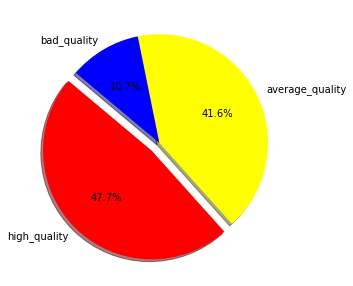

In [57]:
labels = 'high_quality','average_quality','bad_quality'
sizes = [10319, 8981, 2313]
colors = ['red', 'yellow', 'blue']
explode = (0.1, 0, 0)
plt.figure(figsize=(10,5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

- Mostly houses in this data has good quality

In [58]:
df['sqft_above'].describe()

count   21613.0
mean     1788.4
std       828.1
min       290.0
25%      1190.0
50%      1560.0
75%      2210.0
max      9410.0
Name: sqft_above, dtype: float64

In [59]:
df['sqft_above'].value_counts()

1300    212
1010    210
1200    206
1220    192
1140    184
       ... 
2665      1
2601      1
440       1
2473      1
1975      1
Name: sqft_above, Length: 946, dtype: int64

- Mostly houses in this data has sqft above ground level in 1300, 1010, 1200, 1220, 1140 sqft

In [60]:
df['sqft_basement'].describe()

count   21613.0
mean      291.5
std       442.6
min         0.0
25%         0.0
50%         0.0
75%       560.0
max      4820.0
Name: sqft_basement, dtype: float64

In [61]:
df['sqft_basement'].value_counts()

0       13126
600       221
700       218
500       214
800       206
        ...  
792         1
2590        1
935         1
2390        1
248         1
Name: sqft_basement, Length: 306, dtype: int64

- We will binning this feature:
  - 0 : no_basement
  - more than 0 : have_basement

In [62]:
df['sqft_basement_bins'] = pd.cut(df['sqft_basement'], bins=[0,1,4820], labels=['no_basement','have_basement'])

In [63]:
# df.head()
df['sqft_basement_bins'].isna().sum()

13126

In [64]:
df['sqft_basement_bins'].fillna('no_basement', inplace=True)

In [65]:
df['sqft_basement_bins'].isna().sum()

0

In [66]:
df['sqft_basement_bins'].describe()

count           21613
unique              2
top       no_basement
freq            13126
Name: sqft_basement_bins, dtype: object

In [67]:
df[df['sqft_basement_bins'] == 'have_basement']['sqft_basement'].describe()

count   8487.0
mean     742.4
std      405.1
min       10.0
25%      450.0
50%      700.0
75%      980.0
max     4820.0
Name: sqft_basement, dtype: float64

In [68]:
df['sqft_basement_bins'].value_counts()

no_basement      13126
have_basement     8487
Name: sqft_basement_bins, dtype: int64

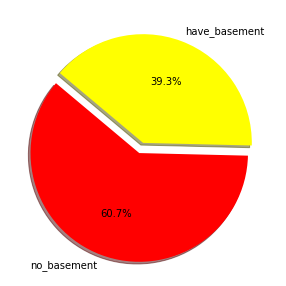

In [69]:
labels = 'no_basement','have_basement'
sizes = [13126, 8487]
colors = ['red', 'yellow']
explode = (0.1, 0)
plt.figure(figsize=(10,5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

- The smallest house's basement in this data is 10 sqft
- The biggest house's basement in this data is 4820 sqft
- Mostly houses in this data (60.7%) hasn't basement

In [70]:
df['yr_built'].describe()

count   21613.0
mean     1971.0
std        29.4
min      1900.0
25%      1951.0
50%      1975.0
75%      1997.0
max      2015.0
Name: yr_built, dtype: float64

In [71]:
df['yr_built'].value_counts()

2014    559
2006    454
2005    450
2004    433
2003    422
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

In [72]:
df['yr_built'].value_counts(normalize=True)*100

2014   2.6
2006   2.1
2005   2.1
2004   2.0
2003   2.0
        ..
1933   0.1
1901   0.1
1902   0.1
1935   0.1
1934   0.1
Name: yr_built, Length: 116, dtype: float64

- The oldest houses in this data was built in 1900
- The youngest houses in this data was built in 2015
- Mostly houses in this data was built in 2003 - 2015

In [73]:
df['yr_renovated'].describe()

count   21613.0
mean       84.4
std       401.7
min         0.0
25%         0.0
50%         0.0
75%         0.0
max      2015.0
Name: yr_renovated, dtype: float64

In [74]:
df['yr_renovated'].value_counts()

0       20699
2014       91
2013       37
2003       36
2000       35
        ...  
1934        1
1959        1
1951        1
1948        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

-We will binning this feature:
  - 0: not_renovated
  - more than 0: is_renovated

In [75]:
df['yr_renovated_bins'] = pd.cut(df['yr_renovated'], bins=[0,1,2015], labels=['not_renovated','is_renovated'])

In [76]:
df['yr_renovated_bins'].isna().sum()

20699

In [77]:
df['yr_renovated_bins'].fillna('not_renovated', inplace=True)

In [78]:
df['yr_renovated_bins'].isna().sum()

0

In [79]:
df['yr_renovated_bins'].describe()

count             21613
unique                2
top       not_renovated
freq              20699
Name: yr_renovated_bins, dtype: object

In [80]:
df['yr_renovated_bins'].value_counts()

not_renovated    20699
is_renovated       914
Name: yr_renovated_bins, dtype: int64

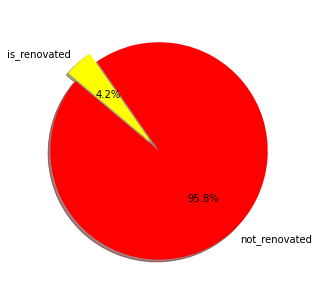

In [81]:
labels = 'not_renovated','is_renovated'
sizes = [20699, 914]
colors = ['red', 'yellow']
explode = (0.1, 0)
plt.figure(figsize=(10,5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

- The lastest renovation house was in 2015
- Mostly renovation house was in 2014
- Overall, mostly houses in this data was not renovated

In [82]:
df['zipcode'].describe()

count   21613.0
mean    98077.9
std        53.5
min     98001.0
25%     98033.0
50%     98065.0
75%     98118.0
max     98199.0
Name: zipcode, dtype: float64

In [83]:
df['zipcode'].value_counts()

98103    602
98038    590
98115    583
98052    574
98117    553
        ... 
98102    105
98010    100
98024     81
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

- Mostly houses in this data has zipcode 98103, 98038, 98115, 98052, 98117

In [84]:
df['sqft_living15'].describe()

count   21613.0
mean     1986.6
std       685.4
min       399.0
25%      1490.0
50%      1840.0
75%      2360.0
max      6210.0
Name: sqft_living15, dtype: float64

In [85]:
df['sqft_living15'].value_counts()

1540    197
1440    195
1560    192
1500    181
1460    169
       ... 
4890      1
2873      1
952       1
3193      1
2049      1
Name: sqft_living15, Length: 777, dtype: int64

- Smallest sqft living for 15 nearest neighboors is 399 sqft
- Biggestsqft living for 15 nearest neighboors is 6210 sqft
- Mostly 15 nearest neighboors has 1540, 1440, 1560, 1500, 1460 sqft living

In [86]:
df['sqft_lot15'].describe()

count    21613.0
mean     12768.5
std      27304.2
min        651.0
25%       5100.0
50%       7620.0
75%      10083.0
max     871200.0
Name: sqft_lot15, dtype: float64

In [87]:
df['sqft_lot15'].value_counts()

5000      427
4000      357
6000      289
7200      211
4800      145
         ... 
8989        1
871200      1
809         1
4907        1
6147        1
Name: sqft_lot15, Length: 8689, dtype: int64

- Smallest sqft lot for 15 nearest neighboors is 651 sqft
- Biggest sqft lot for 15 nearest neighboors is 871200 sqft
- Mostly 15 nearest neighboors has 5000, 4000, 6000, 7200, 4800 sqft lot. This is same with house's sqft lot that sales. In my opinion mostly houses that sale are elite town house

### Bivariate

#### price_bins X latitude X longitude

In [88]:
import folium

In [89]:
df['lat'].value_counts().head()

47.5    17
47.7    17
47.7    17
47.5    17
47.7    16
Name: lat, dtype: int64

In [90]:
df['long'].value_counts().head()

-122.3    116
-122.3    111
-122.4    104
-122.3    100
-122.4     99
Name: long, dtype: int64

In [91]:
m = folium.Map(
    location = [47.4700, -121.8400],
    tiles='OpenStreetMap',
    zoom_start = 10)

for i in range(500,1000):
  if df['price_bins'][i] == 'under_median':
    folium.Marker(
    location=[df['lat'][i], df['long'][i]],
    popup='under_median_house',
    icon=folium.Icon(color='green')
    ).add_to(m)
  elif df['price_bins'][i] == 'median':
    folium.Marker(
    location=[df['lat'][i], df['long'][i]],
    popup='under_median_house',
    icon=folium.Icon(color='yellow')
    ).add_to(m)
  elif df['price_bins'][i] == 'above_median':
    folium.Marker(
    location=[df['lat'][i], df['long'][i]],
    popup='under_median_house',
    icon=folium.Icon(color='red')
    ).add_to(m)

m

- Houses with price above median mostly are located in the center and nearby of city
- Houses with price under median mostly are located far from city

- RECOMMENDATION:
  - Houses that are located in the center and nearby city can priced above median
  - Houses that are located far from city can priced under median

#### price_bins X bedrooms

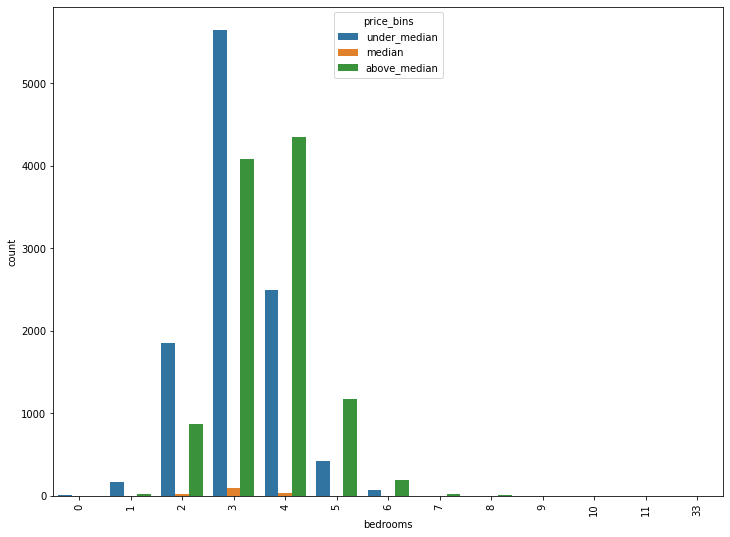

In [92]:
plt.figure(figsize=(12,9))
sns.countplot(x = df['bedrooms'], hue=df['price_bins'])
plt.xticks(rotation=90)
plt.show()

- Houses with 0 - 3 bedrooms mostly under median price
- Houses with more than 3 bedrooms mostly above median price
- RECOMMENDATION:
  - Houses with 0 - 3 bedrooms can priced under median price
  - Houses with more than 3 bedrooms can priced above median price

#### price_bins X bathrooms

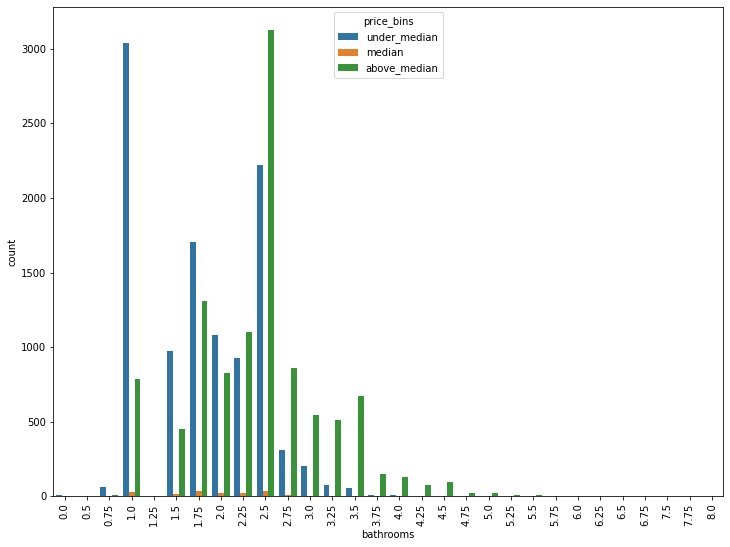

In [93]:
plt.figure(figsize=(12,9))
sns.countplot(x = df['bathrooms'], hue=df['price_bins'])
plt.xticks(rotation=90)
plt.show()

- Houses with 0 - 2 bathrooms mostly under median price
- Houses with more than 2 bathrooms mostly above median price
- RECOMMENDATION:
  - Houses with 0-2 bathrooms can priced under median price
  - Houses with more than 2 bathrooms can proced above median

#### price_bins X sqft_living_bins

- We will binning sqft_living feature:
  - middle-low : 225 - 644
  - middle-up : 645 - 1291
  - luxury : 1292 - 14000
- Binning based on https://www.raywhite.co.id/news/105404tipe-tipe-rumah-berdasarkan-luas-bangunannya and then we convert m2 to sqft

In [94]:
df['sqft_living_bins'] = pd.cut(df['sqft_living'], bins=[225,645,1291,14000], labels=['middle-low','middle-up','luxury'])

In [95]:
df['sqft_living_bins'].describe()

count      21613
unique         3
top       luxury
freq       17599
Name: sqft_living_bins, dtype: object

In [96]:
df['sqft_living_bins'].value_counts()

luxury        17599
middle-up      3931
middle-low       83
Name: sqft_living_bins, dtype: int64

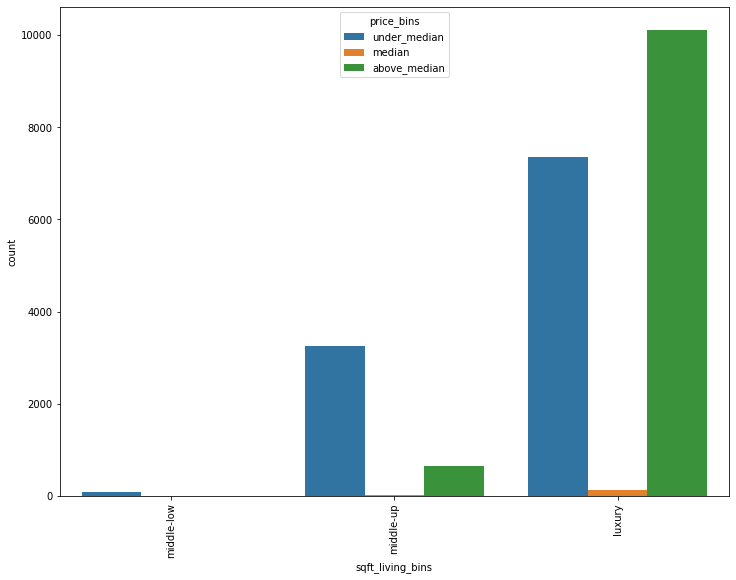

In [97]:
plt.figure(figsize=(12,9))
sns.countplot(x = df['sqft_living_bins'], hue=df['price_bins'])
plt.xticks(rotation=90)
plt.show()

- Middle-low (225 - 644 sqft) and Middle-up (645 - 1291 sqft) houses mostly under median price
- Luxury (> 1291 sqft) houses mostly above median price
- RECOMMENDATION:
  - Middle-low and Middle-up houses can priced under median
  - Luxury houses can priced above median

#### price_bins X floors

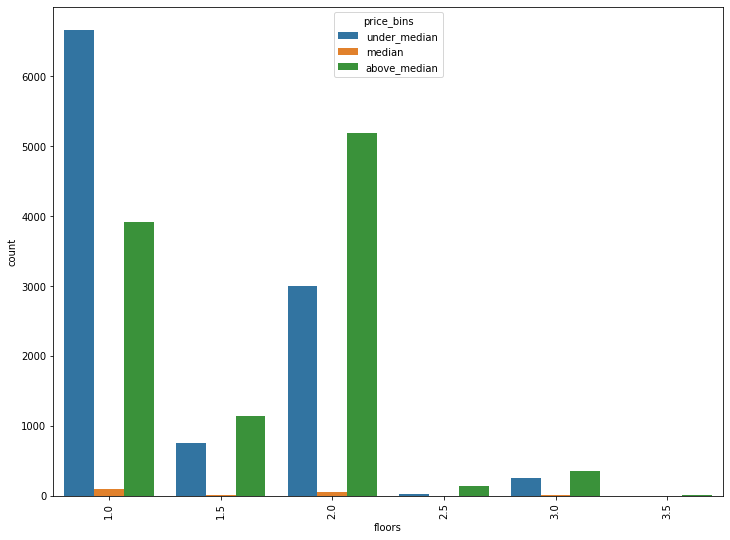

In [98]:
plt.figure(figsize=(12,9))
sns.countplot(x = df['floors'], hue=df['price_bins'])
plt.xticks(rotation=90)
plt.show()

- Houses with 1 floor mostly under median price
- Houses with more than 1 floor mostly above median price
- RECOMMENDATION:
  - Houses with 1 floor can priced under median price
  - Houses with more than 1 floor can priced above median price

#### price_bins X waterfront

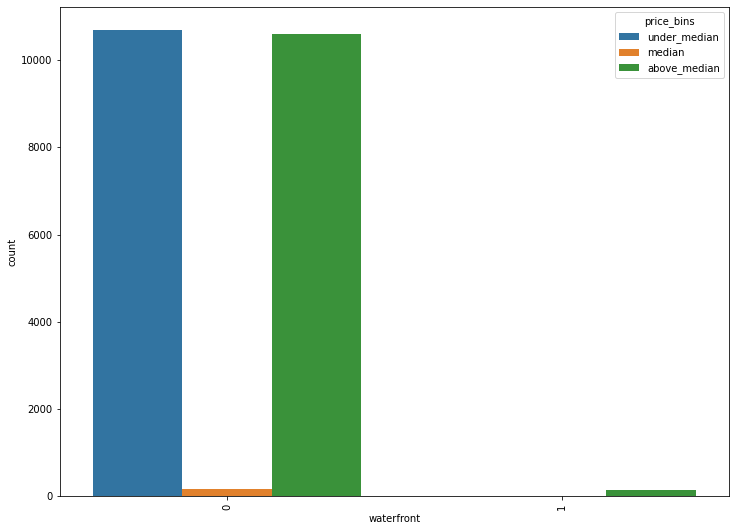

In [99]:
plt.figure(figsize=(12,9))
sns.countplot(x = df['waterfront'], hue=df['price_bins'])
plt.xticks(rotation=90)
plt.show()

- Houses without waterfront almost balance between number of under and above median price
- Houses with waterfront mostly above median price
- RECOMMENDATION:
  - Houses without waterfront can priced under or above median price depends on other variables
  - Houses with waterfront can priced above median price

#### price_bins X view

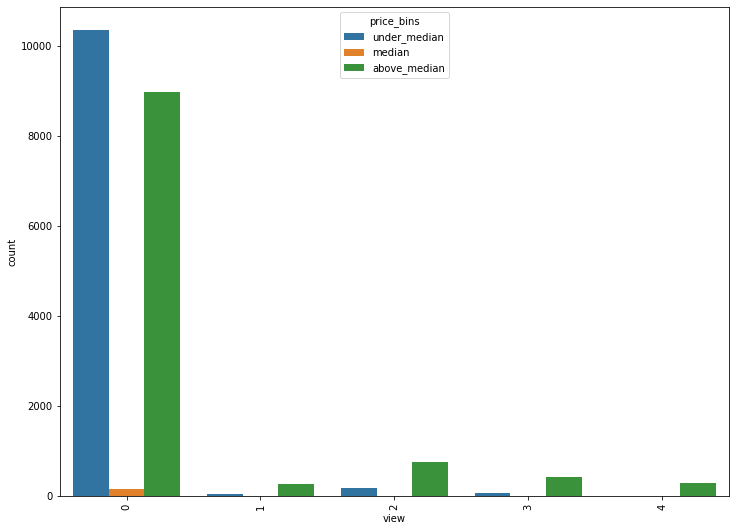

In [100]:
plt.figure(figsize=(12,9))
sns.countplot(x = df['view'], hue=df['price_bins'])
plt.xticks(rotation=90)
plt.show()

- Houses without view mostly under median price
- Houses with except very bad view mostly above median price
- RECOMMENDATION:
  - Houses without view can priced under median price
  - Houses with view can priced above median price

#### price_bins X condition

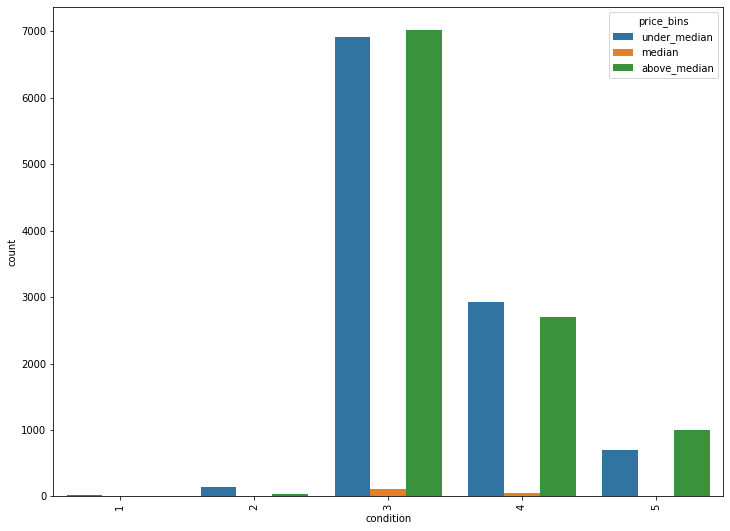

In [101]:
plt.figure(figsize=(12,9))
sns.countplot(x = df['condition'], hue=df['price_bins'])
plt.xticks(rotation=90)
plt.show()

- Houses with very bad, bad, and very good condition mostly under median price
- Houses with best condition mostly above median price
- Houses with good condition are almost balance between under and above median price
- RECOMMENDATION:
  - Houses with very bad, bad, and very good condition can priced under median price
  - Houses with good and best condition can priced above median price

#### price_bins X grade_bins

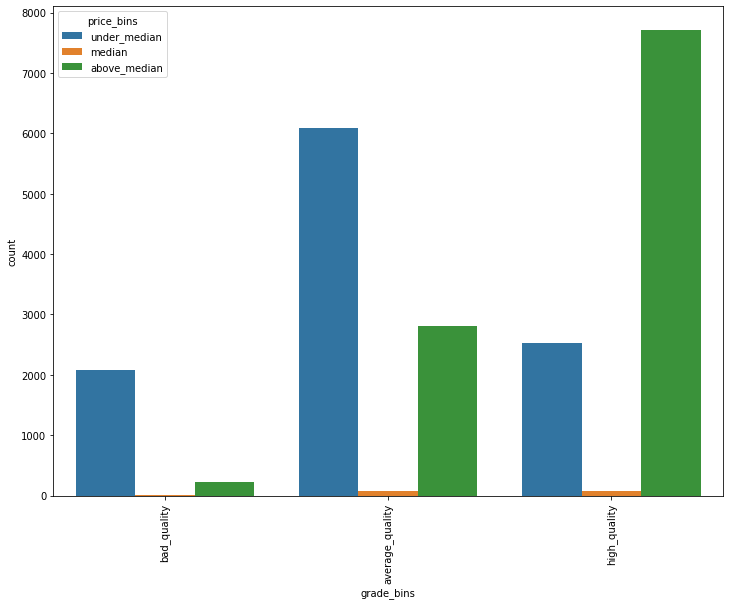

In [102]:
plt.figure(figsize=(12,9))
sns.countplot(x = df['grade_bins'], hue=df['price_bins'])
plt.xticks(rotation=90)
plt.show()

- Houses with bad quality and average quality mostly under median price
- Houses with high quality mostly above median price
- RECOMMENDATION:
  - Houses with bad and average quality can priced under median price
  - Houses with high quality can priced above median price

#### price_bins X sqft_basement_bins

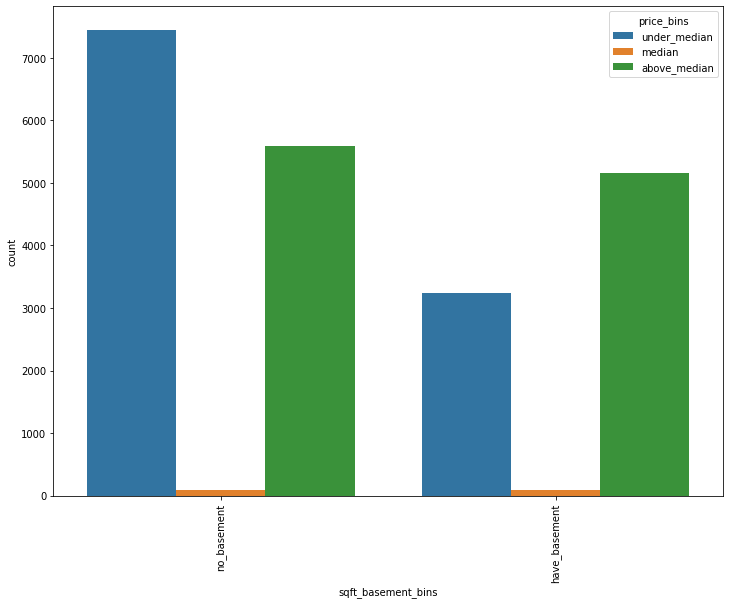

In [103]:
plt.figure(figsize=(12,9))
sns.countplot(x = df['sqft_basement_bins'], hue=df['price_bins'])
plt.xticks(rotation=90)
plt.show()

- Houses without basement mostly under median price
- Houses with basement mostly above median price
- RECOMMENDATION:
  - Houses without basement can priced under median price
  - Houses with basement can priced above median price

#### sqft_basement_bins X sqft_living_bins

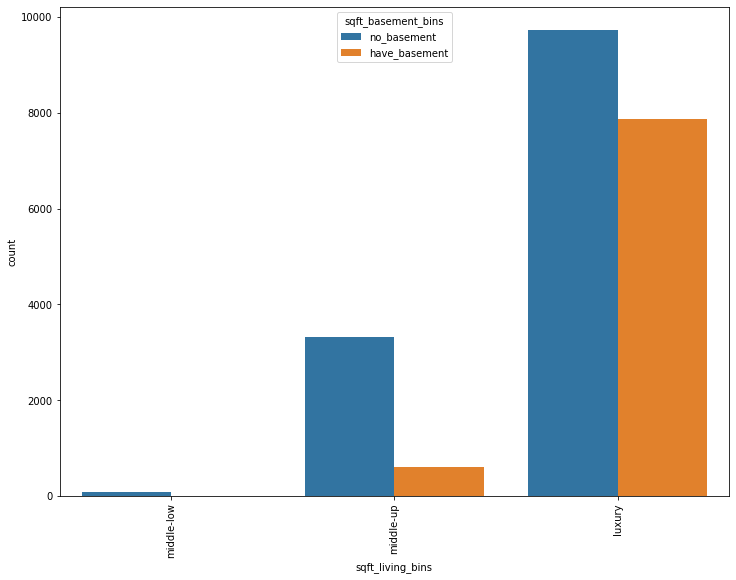

In [104]:
plt.figure(figsize=(12,9))
sns.countplot(x = df['sqft_living_bins'], hue=df['sqft_basement_bins'])
plt.xticks(rotation=90)
plt.show()

- House with basement mostly luxury house (>1292 sqft)

#### price_bins X yr_renovated_bins

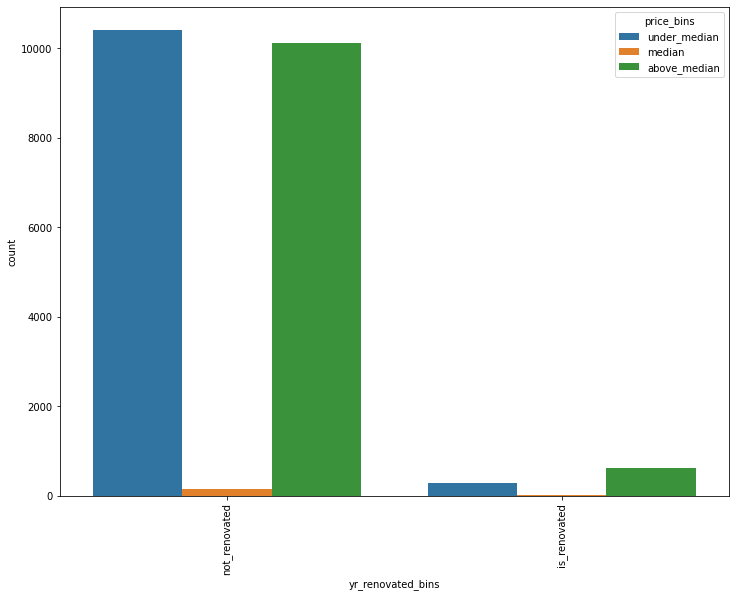

In [105]:
plt.figure(figsize=(12,9))
sns.countplot(x = df['yr_renovated_bins'], hue=df['price_bins'])
plt.xticks(rotation=90)
plt.show()

- Houses that renovated mostly above median price
- Houses that not renovated mostly under median price
- RECOMMENDATION:
  - Houses that not renovated can priced under median price
  - Houses that renovated can priced above median price

#### price_bins X house_age

In [106]:
df['house_age'].describe()

count   21613.0
mean       43.3
std        29.4
min        -1.0
25%        18.0
50%        40.0
75%        63.0
max       115.0
Name: house_age, dtype: float64

- We will binning this feature:
  - young: -1 - 40
  - old: 41 - 115

In [107]:
df['house_age_bins'] = pd.cut(df['house_age'], bins=[-2,40,115], labels=['young','old'])

In [108]:
df[df['house_age'] == -1].head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sale,house_age,price_bins,grade_bins,sqft_basement_bins,yr_renovated_bins,sqft_living_bins,house_age_bins
1763,1832100030,2014-06-25,597326.0,4,4.0,3570,8250,2.0,0,0,3,10,2860,710,2015,0,98040,47.6,-122.2,2230,10000,2014,-1,above_median,high_quality,have_basement,not_renovated,luxury,young
2687,3076500830,2014-10-29,385195.0,1,1.0,710,6000,1.5,0,0,3,6,710,0,2015,0,98144,47.6,-122.3,1440,4800,2014,-1,under_median,bad_quality,no_basement,not_renovated,middle-up,young
7526,9520900210,2014-12-31,614285.0,5,2.8,2730,6401,2.0,0,0,3,8,2730,0,2015,0,98072,47.8,-122.2,2520,6126,2014,-1,above_median,high_quality,no_basement,not_renovated,luxury,young


In [109]:
df['house_age_bins'].value_counts()

young    10980
old      10633
Name: house_age_bins, dtype: int64

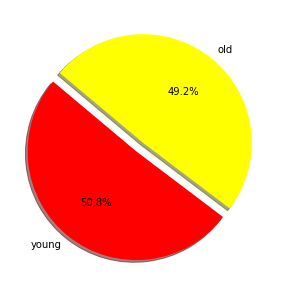

In [110]:
labels = 'young', 'old'
sizes = [10980, 10633]
colors = ['red', 'yellow']
explode = (0.1, 0)
plt.figure(figsize=(10,5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

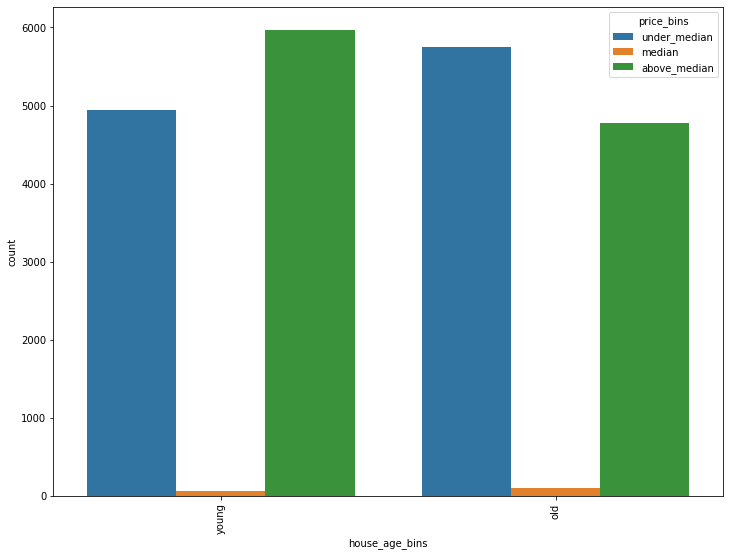

In [111]:
plt.figure(figsize=(12,9))
sns.countplot(x = df['house_age_bins'], hue=df['price_bins'])
plt.xticks(rotation=90)
plt.show()

- Number between young and old house almost balance
- Young houses mostly above median price
- Old houses mostly under median price
- RECOMMENDATION:
  - Young houses can priced above median price
  - Old houses can priced under median price

## Conclusion
- Houses with price above median mostly are located in the center and nearby of city
- Houses with price under median mostly are located far from city
- Houses with 0 - 3 bedrooms mostly under median price
- Houses with more than 3 bedrooms mostly above median price
- Houses with 0 - 2 bathrooms mostly under median price
- Houses with more than 2 bathrooms mostly above median price
- Middle-low (225 - 644 sqft) and Middle-up (645 - 1291 sqft) houses mostly under median price
- Luxury (> 1291 sqft) houses mostly above median price
- Houses with 1 floor mostly under median price
- Houses with more than 1 floor mostly above median price
- Houses without waterfront almost balance between number of under and above median price
- Houses with waterfront mostly above median price
- Houses without view mostly under median price
- Houses with except very bad view mostly above median price
- Houses with very bad, bad, and very good condition mostly under median price
- Houses with best condition mostly above median price
- Houses with good condition are almost balance between under and above median price
- Houses with bad quality and average quality mostly under median price
- Houses with high quality mostly above median price
- Houses without basement mostly under median price
- Houses with basement mostly above median price
- House with basement mostly luxury house (>1292 sqft)
- Houses that renovated mostly above median price
- Houses that not renovated mostly under median price
- Number between young and old house almost balance
- Young houses mostly above median price
- Old houses mostly under median price

## Recommendation
- Houses that are located in the center and nearby city can priced above median
- Houses that are located far from city can priced under median
- Houses with 0 - 3 bedrooms can priced under median price
- Houses with more than 3 bedrooms can priced above median price
- Houses with 0-2 bathrooms can priced under median price
- Houses with more than 2 bathrooms can proced above median
- Middle-low and Middle-up houses can priced under median
- Luxury houses can priced above median
- Houses with 1 floor can priced under median price
- Houses with more than 1 floor can priced above median price
- Houses without waterfront can priced under or above median price depends on other variables
- Houses with waterfront can priced above median price
- Houses without view can priced under median price
- Houses with view can priced above median price
- Houses with very bad, bad, and very good condition can priced under median price
- Houses with good and best condition can priced above median price
- Houses with bad and average quality can priced under median price
- Houses with high quality can priced above median price
- Houses without basement can priced under median price
- Houses with basement can priced above median price
- Houses that not renovated can priced under median price
- Houses that renovated can priced above median price
Young (<= 40 years old) houses can priced above median price
Old (more than 40 years old) houses can priced under median price

## Data Preparation

In [112]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sale,house_age,price_bins,grade_bins,sqft_basement_bins,yr_renovated_bins,sqft_living_bins,house_age_bins
0,7129300520,2014-10-13,221900.0,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5,-122.3,1340,5650,2014,59,under_median,average_quality,no_basement,not_renovated,middle-up,old
1,6414100192,2014-12-09,538000.0,3,2.2,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7,-122.3,1690,7639,2014,63,above_median,average_quality,have_basement,is_renovated,luxury,old
2,5631500400,2015-02-25,180000.0,2,1.0,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7,-122.2,2720,8062,2015,82,under_median,bad_quality,no_basement,not_renovated,middle-up,old
3,2487200875,2014-12-09,604000.0,4,3.0,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5,-122.4,1360,5000,2014,49,above_median,average_quality,have_basement,not_renovated,luxury,old
4,1954400510,2015-02-18,510000.0,3,2.0,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6,-122.0,1800,7503,2015,28,above_median,high_quality,no_basement,not_renovated,luxury,young


### Feature Selections

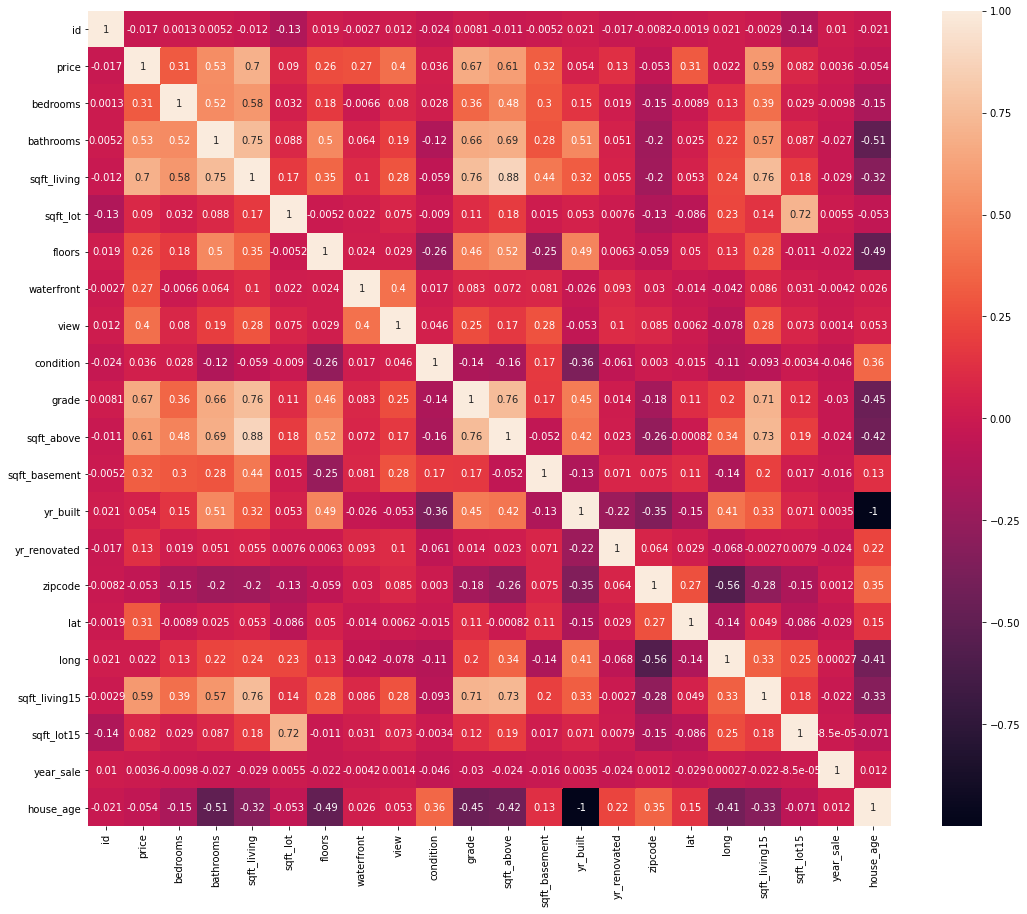

In [113]:
plt.figure(figsize=(18,15))
sns.heatmap(df.corr(), annot=True)
plt.show()

- For now we're not doing feature engineering just want to try, see the evaluation matrix score base model without feature engineering. We just doing feature selections to new variable called 'df_a', the selections will based on correlation matrix above.
- We will drop id, date, sqft_above because it has big correlation with sqft_living so try to avoid bias, sqft_living 15 and sqft_lot15 with same reason. We try with original features from data.

In [114]:
df_a = df.drop(columns=['id','date','sqft_above','sqft_living15','sqft_lot15','year_sale','house_age','price_bins','grade_bins','sqft_basement_bins','yr_renovated_bins','sqft_living_bins','house_age_bins'])
df_a.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,221900.0,3,1.0,1180,5650,1.0,0,0,3,7,0,1955,0,98178,47.5,-122.3
1,538000.0,3,2.2,2570,7242,2.0,0,0,3,7,400,1951,1991,98125,47.7,-122.3
2,180000.0,2,1.0,770,10000,1.0,0,0,3,6,0,1933,0,98028,47.7,-122.2
3,604000.0,4,3.0,1960,5000,1.0,0,0,5,7,910,1965,0,98136,47.5,-122.4
4,510000.0,3,2.0,1680,8080,1.0,0,0,3,8,0,1987,0,98074,47.6,-122.0


## Base Model

In [115]:
X = df_a.drop(columns='price')
y = df_a['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=100)

In [116]:
X_train.head(3)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
16000,3,1.8,1780,11096,1.0,0,0,3,7,570,1979,0,98074,47.6,-122.1
11286,2,2.5,1420,2229,2.0,0,0,3,7,0,2004,0,98059,47.5,-122.2
3201,2,1.0,1790,4000,1.0,0,0,4,7,750,1923,0,98112,47.6,-122.3


### Ridge

In [117]:
base_rid = Ridge()
base_rid.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [118]:
y_pred_rid = base_rid.predict(X_test)
y_pred_train_rid = base_rid.predict(X_train)

In [119]:
r2_base_train_rid = r2_score(y_train, y_pred_train_rid)
r2_base_test_rid = r2_score(y_test, y_pred_rid)
mae_base_train_rid = mean_absolute_error(y_train, y_pred_train_rid)
mae_base_test_rid = mean_absolute_error(y_test, y_pred_rid)
mse_base_train_rid = mean_squared_error(y_train, y_pred_train_rid)
mse_base_test_rid = mean_squared_error(y_test, y_pred_rid)
rmse_base_train_rid = np.sqrt(mse_base_train_rid)
rmse_base_test_rid = np.sqrt(mse_base_test_rid)

data = {
    'R2' : [r2_base_train_rid, r2_base_test_rid],
    'MAE' : [mae_base_train_rid, mae_base_test_rid],
    'MSE' : [mse_base_train_rid, mse_base_test_rid],
    'RMSE' : [rmse_base_train_rid, rmse_base_test_rid]
}
pd.set_option('display.float_format', '{:.2f}'.format)
EM_BASE_RID = pd.DataFrame(data=data, index=['Ridge_base_train','Ridge_base_test'])
EM_BASE_RID

,R2,MAE,MSE,RMSE
Ridge_base_train,0.70,126128.19,40720332079.75,201792.79
Ridge_base_test,0.70,125865.89,40186269354.58,200465.13


### KNN

In [120]:
base_knn = KNeighborsRegressor()
base_knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [121]:
y_pred_knn = base_knn.predict(X_test)
y_pred_train_knn = base_knn.predict(X_train)

In [122]:
r2_base_train_knn = r2_score(y_train, y_pred_train_knn)
r2_base_test_knn = r2_score(y_test, y_pred_knn)
mae_base_train_knn = mean_absolute_error(y_train, y_pred_train_knn)
mae_base_test_knn = mean_absolute_error(y_test, y_pred_knn)
mse_base_train_knn = mean_squared_error(y_train, y_pred_train_knn)
mse_base_test_knn = mean_squared_error(y_test, y_pred_knn)
rmse_base_train_knn = np.sqrt(mse_base_train_knn)
rmse_base_test_knn = np.sqrt(mse_base_test_knn)

data = {
    'R2' : [r2_base_train_knn, r2_base_test_knn],
    'MAE' : [mae_base_train_knn, mae_base_test_knn],
    'MSE' : [mse_base_train_knn, mse_base_test_knn],
    'RMSE' : [rmse_base_train_knn, rmse_base_test_knn]
}
EM_BASE_KNN = pd.DataFrame(data=data, index=['KNN_base_train','KNN_base_test'])
EM_BASE_KNN

,R2,MAE,MSE,RMSE
KNN_base_train,0.67,133035.68,44168823432.75,210163.80
KNN_base_test,0.52,162560.51,64857194027.11,254670.76


### XGBoost

In [123]:
base_xgb = XGBRegressor()
base_xgb.fit(X_train, y_train)

[00:48:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [124]:
y_pred_xgb = base_xgb.predict(X_test)
y_pred_train_xgb = base_xgb.predict(X_train)

In [125]:
r2_base_train_xgb = r2_score(y_train, y_pred_train_xgb)
r2_base_test_xgb = r2_score(y_test, y_pred_xgb)
mae_base_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
mae_base_test_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_base_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
mse_base_test_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_base_train_xgb = np.sqrt(mse_base_train_xgb)
rmse_base_test_xgb = np.sqrt(mse_base_test_xgb)

data = {
    'R2' : [r2_base_train_xgb, r2_base_test_xgb],
    'MAE' : [mae_base_train_xgb, mae_base_test_xgb],
    'MSE' : [mse_base_train_xgb, mse_base_test_xgb],
    'RMSE' : [rmse_base_train_xgb, rmse_base_test_xgb]
}
EM_BASE_XGB = pd.DataFrame(data=data, index=['XGB_base_train','XGB_base_test'])
EM_BASE_XGB

,R2,MAE,MSE,RMSE
XGB_base_train,0.89,73773.84,14284065102.33,119515.96
XGB_base_test,0.86,79038.98,18363755586.37,135512.94


### Evaluation Matrix Base Model

In [126]:
pd.concat([EM_BASE_RID, EM_BASE_KNN, EM_BASE_XGB])

,R2,MAE,MSE,RMSE
Ridge_base_train,0.70,126128.19,40720332079.75,201792.79
Ridge_base_test,0.70,125865.89,40186269354.58,200465.13
KNN_base_train,0.67,133035.68,44168823432.75,210163.80
KNN_base_test,0.52,162560.51,64857194027.11,254670.76
XGB_base_train,0.89,73773.84,14284065102.33,119515.96
XGB_base_test,0.86,79038.98,18363755586.37,135512.94


- XGB has best score, followed by Ridge, and then KNN. XGB and KNN still overfitting

## Data Improvement - Feature Engineering


- Now we will try polynomial for Ridge, scale the data with Standard Scaler and Robust Scaler for KNN, then we put into base model again

### Ridge + Polynomial

In [127]:
poly = PolynomialFeatures(include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [128]:
base_rid = Ridge()
base_rid.fit(X_train_poly, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [129]:
y_pol_rid = base_rid.predict(X_test_poly)
y_pol_train_rid = base_rid.predict(X_train_poly)

In [130]:
r2_pol_train_rid = r2_score(y_train, y_pol_train_rid)
r2_pol_test_rid = r2_score(y_test, y_pol_rid)
mae_pol_train_rid = mean_absolute_error(y_train, y_pol_train_rid)
mae_pol_test_rid = mean_absolute_error(y_test, y_pol_rid)
mse_pol_train_rid = mean_squared_error(y_train, y_pol_train_rid)
mse_pol_test_rid = mean_squared_error(y_test, y_pol_rid)
rmse_pol_train_rid = np.sqrt(mse_pol_train_rid)
rmse_pol_test_rid = np.sqrt(mse_pol_test_rid)

data = {
    'R2' : [r2_pol_train_rid, r2_pol_test_rid],
    'MAE' : [mae_pol_train_rid, mae_pol_test_rid],
    'MSE' : [mse_pol_train_rid, mse_pol_test_rid],
    'RMSE' : [rmse_pol_train_rid, rmse_pol_test_rid]
}
EM_POL_RID = pd.DataFrame(data=data, index=['Ridge_pol_train','Ridge_pol_test'])
EM_POL_RID

,R2,MAE,MSE,RMSE
Ridge_pol_train,0.82,100288.75,24523036367.01,156598.33
Ridge_pol_test,0.81,103242.60,26168370432.25,161766.41


### KNN + Standard Scale

In [131]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.fit_transform(X_test)

In [132]:
base_knn = KNeighborsRegressor()
base_knn.fit(X_train_std, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [133]:
y_std_knn = base_knn.predict(X_test_std)
y_std_train_knn = base_knn.predict(X_train_std)

In [134]:
r2_std_train_knn = r2_score(y_train, y_std_train_knn)
r2_std_test_knn = r2_score(y_test, y_std_knn)
mae_std_train_knn = mean_absolute_error(y_train, y_std_train_knn)
mae_std_test_knn = mean_absolute_error(y_test, y_std_knn)
mse_std_train_knn = mean_squared_error(y_train, y_std_train_knn)
mse_std_test_knn = mean_squared_error(y_test, y_std_knn)
rmse_std_train_knn = np.sqrt(mse_std_train_knn)
rmse_std_test_knn = np.sqrt(mse_std_test_knn)

data = {
    'R2' : [r2_std_train_knn, r2_std_test_knn],
    'MAE' : [mae_std_train_knn, mae_std_test_knn],
    'MSE' : [mse_std_train_knn, mse_std_test_knn],
    'RMSE' : [rmse_std_train_knn, rmse_std_test_knn]
}
EM_STD_KNN = pd.DataFrame(data=data, index=['KNN_std_train','KNN_std_test'])
EM_STD_KNN

,R2,MAE,MSE,RMSE
KNN_std_train,0.86,73972.61,19312630919.50,138969.89
KNN_std_test,0.78,92063.21,29345371020.15,171304.91


### KNN + Robust Scale

In [135]:
rob = RobustScaler()
X_train_rob = rob.fit_transform(X_train)
X_test_rob = rob.fit_transform(X_test)

In [136]:
base_knn = KNeighborsRegressor()
base_knn.fit(X_train_rob, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [137]:
y_rob_knn = base_knn.predict(X_test_rob)
y_rob_train_knn = base_knn.predict(X_train_rob)

In [138]:
r2_rob_train_knn = r2_score(y_train, y_rob_train_knn)
r2_rob_test_knn = r2_score(y_test, y_rob_knn)
mae_rob_train_knn = mean_absolute_error(y_train, y_rob_train_knn)
mae_rob_test_knn = mean_absolute_error(y_test, y_rob_knn)
mse_rob_train_knn = mean_squared_error(y_train, y_rob_train_knn)
mse_rob_test_knn = mean_squared_error(y_test, y_rob_knn)
rmse_rob_train_knn = np.sqrt(mse_rob_train_knn)
rmse_rob_test_knn = np.sqrt(mse_rob_test_knn)

data = {
    'R2' : [r2_rob_train_knn, r2_rob_test_knn],
    'MAE' : [mae_rob_train_knn, mae_rob_test_knn],
    'MSE' : [mse_rob_train_knn, mse_rob_test_knn],
    'RMSE' : [rmse_rob_train_knn, rmse_rob_test_knn]
}
EM_ROB_KNN = pd.DataFrame(data=data, index=['KNN_rob_train','KNN_rob_test'])
EM_ROB_KNN

,R2,MAE,MSE,RMSE
KNN_rob_train,0.84,78820.70,22043034209.70,148468.97
KNN_rob_test,0.71,99916.44,38802947931.88,196984.64


### Evaluation Matrix FE

In [139]:
pd.concat([EM_BASE_RID, EM_POL_RID, EM_BASE_KNN, EM_STD_KNN, EM_ROB_KNN])

,R2,MAE,MSE,RMSE
Ridge_base_train,0.70,126128.19,40720332079.75,201792.79
Ridge_base_test,0.70,125865.89,40186269354.58,200465.13
Ridge_pol_train,0.82,100288.75,24523036367.01,156598.33
Ridge_pol_test,0.81,103242.60,26168370432.25,161766.41
KNN_base_train,0.67,133035.68,44168823432.75,210163.80
KNN_base_test,0.52,162560.51,64857194027.11,254670.76
KNN_std_train,0.86,73972.61,19312630919.50,138969.89
KNN_std_test,0.78,92063.21,29345371020.15,171304.91
KNN_rob_train,0.84,78820.70,22043034209.70,148468.97
KNN_rob_test,0.71,99916.44,38802947931.88,196984.64


## Data Improvement 2 - Feature Engineering


- Now we will transform y_train and y_test then we put into model below

In [140]:
y_train = np.log(y_train)
y_test = np.log(y_test)

### Ridge + Polynomial

In [141]:
poly = PolynomialFeatures(include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [142]:
base_rid = Ridge()
base_rid.fit(X_train_poly, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [143]:
y_pol_rid = base_rid.predict(X_test_poly)
y_pol_train_rid = base_rid.predict(X_train_poly)

In [144]:
r2_pol_train_rid = r2_score(y_train, y_pol_train_rid)
r2_pol_test_rid = r2_score(y_test, y_pol_rid)
mae_pol_train_rid = mean_absolute_error(y_train, y_pol_train_rid)
mae_pol_test_rid = mean_absolute_error(y_test, y_pol_rid)
mse_pol_train_rid = mean_squared_error(y_train, y_pol_train_rid)
mse_pol_test_rid = mean_squared_error(y_test, y_pol_rid)
rmse_pol_train_rid = np.sqrt(mse_pol_train_rid)
rmse_pol_test_rid = np.sqrt(mse_pol_test_rid)

data = {
    'R2' : [r2_pol_train_rid, r2_pol_test_rid],
    'MAE' : [mae_pol_train_rid, mae_pol_test_rid],
    'MSE' : [mse_pol_train_rid, mse_pol_test_rid],
    'RMSE' : [rmse_pol_train_rid, rmse_pol_test_rid]
}
EM_POL_RID2 = pd.DataFrame(data=data, index=['Ridge_pol_train2','Ridge_pol_test2'])
EM_POL_RID2

,R2,MAE,MSE,RMSE
Ridge_pol_train2,0.82,0.17,0.05,0.22
Ridge_pol_test2,0.82,0.17,0.05,0.23


### KNN + Standard Scale

In [145]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.fit_transform(X_test)

In [146]:
base_knn = KNeighborsRegressor()
base_knn.fit(X_train_std, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [147]:
y_std_knn = base_knn.predict(X_test_std)
y_std_train_knn = base_knn.predict(X_train_std)

In [148]:
r2_std_train_knn = r2_score(y_train, y_std_train_knn)
r2_std_test_knn = r2_score(y_test, y_std_knn)
mae_std_train_knn = mean_absolute_error(y_train, y_std_train_knn)
mae_std_test_knn = mean_absolute_error(y_test, y_std_knn)
mse_std_train_knn = mean_squared_error(y_train, y_std_train_knn)
mse_std_test_knn = mean_squared_error(y_test, y_std_knn)
rmse_std_train_knn = np.sqrt(mse_std_train_knn)
rmse_std_test_knn = np.sqrt(mse_std_test_knn)

data = {
    'R2' : [r2_std_train_knn, r2_std_test_knn],
    'MAE' : [mae_std_train_knn, mae_std_test_knn],
    'MSE' : [mse_std_train_knn, mse_std_test_knn],
    'RMSE' : [rmse_std_train_knn, rmse_std_test_knn]
}
EM_STD_KNN2 = pd.DataFrame(data=data, index=['KNN_std_train2','KNN_std_test2'])
EM_STD_KNN2

,R2,MAE,MSE,RMSE
KNN_std_train2,0.88,0.13,0.03,0.18
KNN_std_test2,0.82,0.16,0.05,0.22


### KNN + Robust Scale

In [149]:
rob = RobustScaler()
X_train_rob = rob.fit_transform(X_train)
X_test_rob = rob.fit_transform(X_test)

In [150]:
base_knn = KNeighborsRegressor()
base_knn.fit(X_train_rob, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [151]:
y_rob_knn = base_knn.predict(X_test_rob)
y_rob_train_knn = base_knn.predict(X_train_rob)

In [152]:
r2_rob_train_knn = r2_score(y_train, y_rob_train_knn)
r2_rob_test_knn = r2_score(y_test, y_rob_knn)
mae_rob_train_knn = mean_absolute_error(y_train, y_rob_train_knn)
mae_rob_test_knn = mean_absolute_error(y_test, y_rob_knn)
mse_rob_train_knn = mean_squared_error(y_train, y_rob_train_knn)
mse_rob_test_knn = mean_squared_error(y_test, y_rob_knn)
rmse_rob_train_knn = np.sqrt(mse_rob_train_knn)
rmse_rob_test_knn = np.sqrt(mse_rob_test_knn)

data = {
    'R2' : [r2_rob_train_knn, r2_rob_test_knn],
    'MAE' : [mae_rob_train_knn, mae_rob_test_knn],
    'MSE' : [mse_rob_train_knn, mse_rob_test_knn],
    'RMSE' : [rmse_rob_train_knn, rmse_rob_test_knn]
}
EM_ROB_KNN2 = pd.DataFrame(data=data, index=['KNN_rob_train2','KNN_rob_test2'])
EM_ROB_KNN2

,R2,MAE,MSE,RMSE
KNN_rob_train2,0.87,0.14,0.04,0.19
KNN_rob_test2,0.80,0.17,0.06,0.24


### XGBoost + Transform Target

In [153]:
base_xgb = XGBRegressor()
base_xgb.fit(X_train, y_train)

[00:49:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [154]:
y_t_xgb = base_xgb.predict(X_test)
y_t_train_xgb = base_xgb.predict(X_train)

In [155]:
r2_t_train_xgb = r2_score(y_train, y_t_train_xgb)
r2_t_test_xgb = r2_score(y_test, y_t_xgb)
mae_t_train_xgb = mean_absolute_error(y_train, y_t_train_xgb)
mae_t_test_xgb = mean_absolute_error(y_test, y_t_xgb)
mse_t_train_xgb = mean_squared_error(y_train, y_t_train_xgb)
mse_t_test_xgb = mean_squared_error(y_test, y_t_xgb)
rmse_t_train_xgb = np.sqrt(mse_t_train_xgb)
rmse_t_test_xgb = np.sqrt(mse_t_test_xgb)

data = {
    'R2' : [r2_t_train_xgb, r2_t_test_xgb],
    'MAE' : [mae_t_train_xgb, mae_t_test_xgb],
    'MSE' : [mse_t_train_xgb, mse_t_test_xgb],
    'RMSE' : [rmse_t_train_xgb, rmse_t_test_xgb]
}
EM_T_XGB = pd.DataFrame(data=data, index=['XGB_t_train','XGB_t_test'])
EM_T_XGB

,R2,MAE,MSE,RMSE
XGB_t_train,0.88,0.13,0.03,0.18
XGB_t_test,0.88,0.14,0.03,0.18


### Evaluation Matrix FE 2

In [156]:
pd.concat([EM_BASE_RID, EM_POL_RID, EM_POL_RID2, EM_BASE_KNN, EM_STD_KNN, EM_ROB_KNN, EM_STD_KNN2, EM_ROB_KNN2, EM_BASE_XGB, EM_T_XGB])

,R2,MAE,MSE,RMSE
Ridge_base_train,0.70,126128.19,40720332079.75,201792.79
Ridge_base_test,0.70,125865.89,40186269354.58,200465.13
Ridge_pol_train,0.82,100288.75,24523036367.01,156598.33
Ridge_pol_test,0.81,103242.60,26168370432.25,161766.41
Ridge_pol_train2,0.82,0.17,0.05,0.22
Ridge_pol_test2,0.82,0.17,0.05,0.23
KNN_base_train,0.67,133035.68,44168823432.75,210163.80
KNN_base_test,0.52,162560.51,64857194027.11,254670.76
KNN_std_train,0.86,73972.61,19312630919.50,138969.89
KNN_std_test,0.78,92063.21,29345371020.15,171304.91


- Best score is XGB_t so far

## Hyperparameter Tuning

### KNN + Hyperparameter Tuning
- We will use KNN_std_train2 and KNN_std_train2 to put into KNN with hyperparameter tuning

In [158]:
knn = KNeighborsRegressor()
param_knn = {"n_neighbors" : [3,5,7,9,11],
            "weights" : ["uniform", "distance"],
            "p" : [1,2]}

In [159]:
model_knn = GridSearchCV(estimator=knn, param_grid=param_knn, scoring='r2', n_jobs = -1, cv = 5, verbose=1)
model_knn.fit(X_train_std, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=1)

In [160]:
model_knn.best_params_

{'n_neighbors': 11, 'p': 1, 'weights': 'distance'}

In [161]:
model_knn.best_score_

0.8386756931452444

In [162]:
knn_tuned = model_knn.best_estimator_
y_tune_knn = knn_tuned.predict(X_test_std)
y_tune_train_knn = knn_tuned.predict(X_train_std)

In [166]:
r2_tune_train_knn = r2_score(y_train, y_tune_train_knn)
r2_tune_test_knn = r2_score(y_test, y_tune_knn)
mae_tune_train_knn = mean_absolute_error(y_train, y_tune_train_knn)
mae_tune_test_knn = mean_absolute_error(y_test, y_tune_knn)
mse_tune_train_knn = mean_squared_error(y_train, y_tune_train_knn)
mse_tune_test_knn = mean_squared_error(y_test, y_tune_knn)
rmse_tune_train_knn = np.sqrt(mse_tune_train_knn)
rmse_tune_test_knn = np.sqrt(mse_tune_test_knn)

data = {
    "R2" : [r2_tune_train_knn, r2_tune_test_knn],
    "MAE" : [mae_tune_train_knn, mae_tune_test_knn],
    "MSE" : [mse_tune_train_knn, mse_tune_test_knn],
    "RMSE" : [rmse_tune_train_knn, rmse_tune_test_knn]
}
EM_TUN_KNN = pd.DataFrame(data=data, index=['KNN_tune_train','KNN_tune_test'])
EM_TUN_KNN

,R2,MAE,MSE,RMSE
KNN_tune_train,1.00,0.00,0.00,0.03
KNN_tune_test,0.85,0.15,0.04,0.20


### XGBoost + Hyperparameter Tuning
- We use XGB_t_train and XGB_t_test

In [167]:
xgbr = XGBRegressor()
param_xgbr = {"learning_rate" : [0.05, 0.10, 0.15, 0.20],
             "max_depth" : [3, 4, 5, 6],
             "min_child_weight" : [1, 3, 5, 7],
             "gamma" : [0.0, 0.1, 0.2, 0.3],
             "colsample_bytree" : [0.5, 1.0, 2.0, 3.0]}

In [168]:
model_xgb = GridSearchCV(estimator=xgbr, param_grid=param_xgbr, scoring='r2', n_jobs = -1, cv = 5, verbose=1)
model_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 5120 out of 5120 | elapsed: 31.6min finished


[01:33:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 1.0, 2.0, 3.0],
                         'gamma': [0.0, 0.1, 0.2, 0.3],
           

In [169]:
model_xgb.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.0,
 'learning_rate': 0.2,
 'max_depth': 6,
 'min_child_weight': 7}

In [170]:
model_xgb.best_score_

0.8985484993397334

In [171]:
xgb_tuned = model_xgb.best_estimator_
y_tune_xgb = xgb_tuned.predict(X_test)
y_tune_train_xgb = xgb_tuned.predict(X_train)

In [174]:
r2_tune_train_x = r2_score(y_train, y_tune_train_xgb)
r2_tune_test_x = r2_score(y_test, y_tune_xgb)
mae_tune_train_x = mean_absolute_error(y_train, y_tune_train_xgb)
mae_tune_test_x = mean_absolute_error(y_test, y_tune_xgb)
mse_tune_train_x = mean_squared_error(y_train, y_tune_train_xgb)
mse_tune_test_x = mean_squared_error(y_test, y_tune_xgb)
rmse_tune_train_x = np.sqrt(mse_tune_train_x)
rmse_tune_test_x = np.sqrt(mse_tune_test_x)

data = {
    "R2" : [r2_tune_train_x, r2_tune_test_x],
    "MAE" : [mae_tune_train_x, mae_tune_test_x],
    "MSE" : [mse_tune_train_x, mse_tune_test_x],
    "RMSE" : [rmse_tune_train_x, rmse_tune_test_x]
}
EM_TUN_XGB = pd.DataFrame(data=data, index=['XGB_tune_train','XGB_tune_test'])
EM_TUN_XGB

,R2,MAE,MSE,RMSE
XGB_tune_train,0.94,0.10,0.02,0.13
XGB_tune_test,0.91,0.12,0.03,0.16


### Evaluation Matrix All

In [175]:
pd.concat([EM_BASE_RID, EM_POL_RID, EM_POL_RID2, EM_BASE_KNN, EM_STD_KNN, EM_STD_KNN2, EM_ROB_KNN, EM_ROB_KNN2, EM_TUN_KNN, EM_BASE_XGB, EM_T_XGB, EM_TUN_XGB])

,R2,MAE,MSE,RMSE
Ridge_base_train,0.70,126128.19,40720332079.75,201792.79
Ridge_base_test,0.70,125865.89,40186269354.58,200465.13
Ridge_pol_train,0.82,100288.75,24523036367.01,156598.33
Ridge_pol_test,0.81,103242.60,26168370432.25,161766.41
Ridge_pol_train2,0.82,0.17,0.05,0.22
Ridge_pol_test2,0.82,0.17,0.05,0.23
KNN_base_train,0.67,133035.68,44168823432.75,210163.80
KNN_base_test,0.52,162560.51,64857194027.11,254670.76
KNN_std_train,0.86,73972.61,19312630919.50,138969.89
KNN_std_test,0.78,92063.21,29345371020.15,171304.91


## Conclusion

- Ridge:
  - Best score from ridge is still Ridge + Polynomial + price feature transformation, fit in 0.82
- KNN:
  - Best score from KNN is KNN + Hyperparameter Tuning, test score reach 0.85 although the score are overfitting among train and test
- XGBoost:
  - Best score from XGB is XGBoost + Hyperparameter Tuning, test score reach 0.91 although the score are overfitting among train and test. Also this is highest test score than other algorithms

## This is not the end of the notebook, just to be continued